TODO:
//

1) Fit an (exponential) function to the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

import pickle
import os
import math
import sys
import numpy
import random
import time
import steps.model as smodel
import steps.solver as solvmod
import steps.mpi.solver as mpisolvmod
import steps.geom as stetmesh
import steps.rng as srng
import steps.utilities.meshio as smeshio
import steps.utilities.meshctrl as meshctrl


# from termcolor import colored
from utils.printProgressBar import printProgressBar

-----------------------------------------------------------------
STEPS is running in parallel mode with  1  processes
-----------------------------------------------------------------


In [2]:
def getFurthestPointInTri(CaSensTris):
    V = []
    for CaSensTri in CaSensTris:
        vert_ids = mesh.getTri(CaSensTris[0])
        vertices = [mesh.getVertex(vert) for vert in vert_ids]
        V += [getP2Pdist(vertext, cbaryc) for vertext in vertices]
    return max(V) * 1.001

def draw_polygon_coll(ax, mesh, tris, sf=1, ln=1, pg=1, c=[0,0,1], alpha=0.1, linewidths=0.5, linestyles=':'):
    Pcoll = []
    for triID in tris:
        P = []
        for verID in mesh.getTri(triID):
            triVertex = tuple(mesh.getVertex(verID))
            P.append(triVertex)
        Pcoll.append(P)
    if ln==1:
        collection = Line3DCollection(Pcoll, colors=c, linewidths=linewidths, linestyles=linestyles)
        ax.add_collection3d(collection)
    if pg==1:
        collection = Poly3DCollection(Pcoll)
        collection.set_facecolor((c[0], c[1], c[2], alpha))
        
    ax.add_collection3d(collection)
    ax.set_xlim(0, SCALING_FACTOR)
    ax.set_ylim(0, SCALING_FACTOR)
    ax.set_zlim(0, SCALING_FACTOR)

def getRadius(all_surf_tris):
    dist = []
    for st in all_surf_tris:
        vertices = [mesh.getVertex(i) for i in mesh.getTri(st)]
        for i in vertices:
            dist.append(getP2Pdist(i, cbaryc))
    return max(dist)/2

def getP2Pdist(p0,p1):
    d = 0
    for i, j in zip(p0, p1):
        d += (i-j)**2
    return np.sqrt(d)

def getbin(distance, min_dist, max_dist, nbins):
    global bin_edges
    edges = np.linspace(min_dist, max_dist, nbins+1)
    bin_edges = edges
    return np.digitize(distance,edges[:-1],right=True)

def getBinnedAzTris(NotCaSensTris, cbaryc, mesh, AZ_RADIUS, nbins):
    mat = [] # distances from the origin to tri barycenters:
    for tri in NotCaSensTris:
        baryc = mesh.getTriBarycenter(tri)
        DistToTri = getP2Pdist(baryc, cbaryc)
        mat.append((tri, DistToTri, getbin(DistToTri, CaSensRadius, AZ_RADIUS, nbins)))
    return mat
    
def getRndTriInDistBin(bin_id, mat):
    ss = [j for j in mat if j[2]==bin_id]
    return random.sample(ss,1)[0][0]

def plotCircleOnShereThruPoint(ax, pointOnSphere):
    density = 500
    theta = np.linspace(0, 2*np.pi, density)
    X,Y,Z = [],[],[]
    r = np.sqrt(pointOnSphere[0]**2 + pointOnSphere[1]**2)
    X = r * np.cos(theta)
    Y = r * np.sin(theta)
    Z = np.repeat(pointOnSphere[2], density)
    ax.scatter(X,Y,Z, s=0.2, c='r')

def getEdgePoint(bin_edge, mesh):
    R = getRadius(all_surf_tris)
    alpha = 2 * np.arcsin(bin_edge/(2*R))
    beta = 90-alpha
    MN = R*np.sin(alpha)
    ON = np.sqrt(bin_edge**2 - MN**2)
    return [MN, 0, ON]

In [3]:
# The diffusion constant for our diffusing species (m^2/s)

# meshfile = 'meshes/cyl4_5K.inp'
# meshfile = 'meshes/cyl4_70Ktets.inp'
meshfile = 'meshes/cyl4_20Ktets.inp'
# meshfile = 'meshes/cyl4_10Ktets.inp'
DCST = 0.2e-10
cbaryc = [0, 0, 0]
SCALING_FACTOR = 1e-6 # whole to micro
AZ_RADIUS = 0.25 * SCALING_FACTOR

nbins = 9

print('SCALING_FACTOR: {}'.format(SCALING_FACTOR))

SCALING_FACTOR: 1e-06


SD: 1.80
M:  32.09


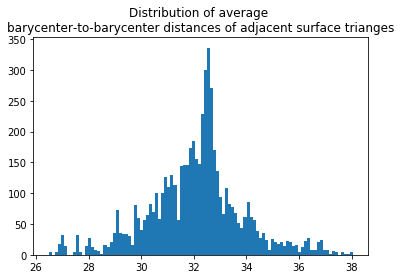

In [64]:
dd = []
for i in surftris:
    for j in surftris:
        dd.append(getP2Pdist(
            mesh.getTriBarycenter(i),
            mesh.getTriBarycenter(j))*1e9)
dd = sorted(dd)[1900:7500]
a = plt.hist(dd, 100)
plt.title('Distribution of average \nbarycenter-to-barycenter distances of adjacent surface trianges')

print('SD: {:.2f}'.format(np.std(dd)))
print('M:  {:.2f}'.format(np.mean(dd)))

In [4]:
mesh, nodeproxy, tetproxy, triproxy = smeshio.importAbaqus(meshfile, SCALING_FACTOR)

tetgroups = tetproxy.blocksToGroups()
CS_tet_IDs = tetgroups['cytosol']
ER_tet_IDs = tetgroups['ER']
print("=======================================================")
print("                   GEOMETRY STATS:                     ")
print("=======================================================")
print("_______________________________________________________")

print('number of tets in CS: ', CS_tet_IDs.__len__())
print('number of tets in ER: ', ER_tet_IDs.__len__())
print('overlapping tets in CS and ER:', set(CS_tet_IDs).intersection(ER_tet_IDs))  

ERvol = sum([mesh.getTetVol(i) for i in ER_tet_IDs])
CSvol = sum([mesh.getTetVol(i) for i in CS_tet_IDs])

print('ER volume: {:.4f} um3'.format(ERvol * 1e18))
print('CS volume: {:.4f} um3'.format(CSvol * 1e18))
print('Total vol: {:.4f} um3'.format((CSvol + ERvol) * 1e18))

print("_______________________________________________________")

# get tets and tris in AZ:
triBARYC = []
surftris = mesh.getSurfTris()

surftrirads, in_az = [], []
for surftriID in surftris:
    baryc = mesh.getTriBarycenter(surftriID)
    triBARYC.append(baryc)
    r = math.sqrt(math.pow((baryc[0]-cbaryc[0]),2) \
                    + math.pow((baryc[1]-cbaryc[1]),2) \
                        + math.pow((baryc[2]-cbaryc[2]),2))
    surftrirads.append(r)
    in_az.append(True if r <= AZ_RADIUS else False)
zipped0 = zip(surftrirads, surftris, in_az)
zipped0 = sorted(zipped0, key=lambda x: x[0])
az_tris = [i[1] for i in zipped0 if i[0]<AZ_RADIUS and i[2]==True]

# get surface tetrahedrons within the active zone:
az_tets = [mesh.getTriTetNeighb(i)[0] for i in az_tris]

# get the triangles of those AZ tetrahedrons:
az_tet_tris = []
for az_tet in az_tets:
    az_quart = mesh.getTetTriNeighb(az_tet)
    for i in az_quart:
        az_tet_tris.append(i)
az_area = sum([mesh.getTriArea(i) for i in az_tris])
print('Tris in AZ: ', len(az_tris))
print('Tets in AZ: ', len(az_tets))
print('AZ area {:.4f} um2'.format(az_area * 1e12))
print("_______________________________________________________")

memb_area = sum([mesh.getTriArea(i) for i in surftris])
print('Memb. area {:.4f} um2'.format(memb_area * 1e12))
print("_______________________________________________________")

print('Furthest distances along axes (x, y, z)')
for ax in range(3):
    print('{:.4f} um'. format(max([triBARYC[i][ax] for i in range(len(triBARYC))]) * 1e6))
    
print('Origin (x, y, z)')
print(cbaryc)

print("_______________________________________________________")

CaSensTris = [zipped0[i][1] for i in range(6)]
NotCaSensTris = list(set(az_tris)-set(CaSensTris))
NotCaSensTris_area = sum([mesh.getTriArea(i) for i in NotCaSensTris])
print('NotCaSensTris:  {}'.format(len(NotCaSensTris)))
print('NotCaSensTris_area:  {:.4f} um2'.format(NotCaSensTris_area * 1e12))
print('Ca sensor tris: {}'.format(CaSensTris))
CaSensTets = [mesh.getTriTetNeighb(i)[0] for i in CaSensTris]
NotCaSensTets = list(set(az_tets)-set(CaSensTets))
print('NotCaSensTets: {}'.format(len(NotCaSensTets)))
print('CaSensTets:    {}'.format(len(CaSensTets)))


NotAzTris = list(set(surftris) - set(NotCaSensTris) - set(CaSensTris))

# get the furthest (from the origin) vertext to inject AP current
furthest = max([triBARYC[i][2] for i in range(len(triBARYC))])
furthest_tet = mesh.findTetByPoint([0,0,furthest])
furthest_tet_verts = mesh.getTet(furthest_tet)
furthest_vertex_id = np.argmin([mesh.getVertex(i)[2] for i in furthest_tet_verts])
furthest_vertex_id = furthest_tet_verts[furthest_vertex_id]

print('Furthest vertex ID: {}'.format(furthest_vertex_id))

CaSensRadius = getFurthestPointInTri(CaSensTris)


# sort CS tets by distance from the origin:
tetBARYC, CStetrads = [], []
for CS_tet_id in CS_tet_IDs:
    baryc = mesh.getTetBarycenter(CS_tet_id)
    tetBARYC.append(baryc)
    r = math.sqrt(math.pow((baryc[0]-cbaryc[0]),2) \
                    + math.pow((baryc[1]-cbaryc[1]),2) \
                        + math.pow((baryc[2]-cbaryc[2]),2))
    CStetrads.append(r)
tmp = zip(CStetrads, CS_tet_IDs)
sorted_CS_tets = sorted(tmp, key=lambda x: x[0])


all_ER_tris = meshctrl.findOverlapTris(mesh, CS_tet_IDs, ER_tet_IDs)
all_surf_tris = mesh.getSurfTris()
cent_tet = mesh.findTetByPoint([cbaryc[0], cbaryc[1], cbaryc[2] + 0.001*SCALING_FACTOR])
cent_tets = mesh.getTetTriNeighb(cent_tet)
binnedAzTris = getBinnedAzTris(NotCaSensTris, cbaryc, mesh, AZ_RADIUS, nbins)

Reading Abaqus file...
Number of nodes imported:  3932
Number of tetrahedrons imported:  20740
Number of triangles imported:  0
creating Tetmesh object in STEPS...
Tetmesh object created.
                   GEOMETRY STATS:                     
_______________________________________________________
number of tets in CS:  19942
number of tets in ER:  798
overlapping tets in CS and ER: set()
ER volume: 0.0133 um3
CS volume: 0.3661 um3
Total vol: 0.3795 um3
_______________________________________________________
Tris in AZ:  138
Tets in AZ:  138
AZ area 0.1867 um2
_______________________________________________________
Memb. area 2.5364 um2
_______________________________________________________
Furthest distances along axes (x, y, z)
0.4484 um
0.4485 um
0.8976 um
Origin (x, y, z)
[0, 0, 0]
_______________________________________________________
NotCaSensTris:  132
NotCaSensTris_area:  0.1784 um2
Ca sensor tris: [11506, 23274, 26229, 24366, 17690, 21532]
NotCaSensTets: 132
CaSensTets:    

<img src="images/Bouton.png" alt="Drawing" style="width: 350px;"/>

<IPython.core.display.Javascript object>


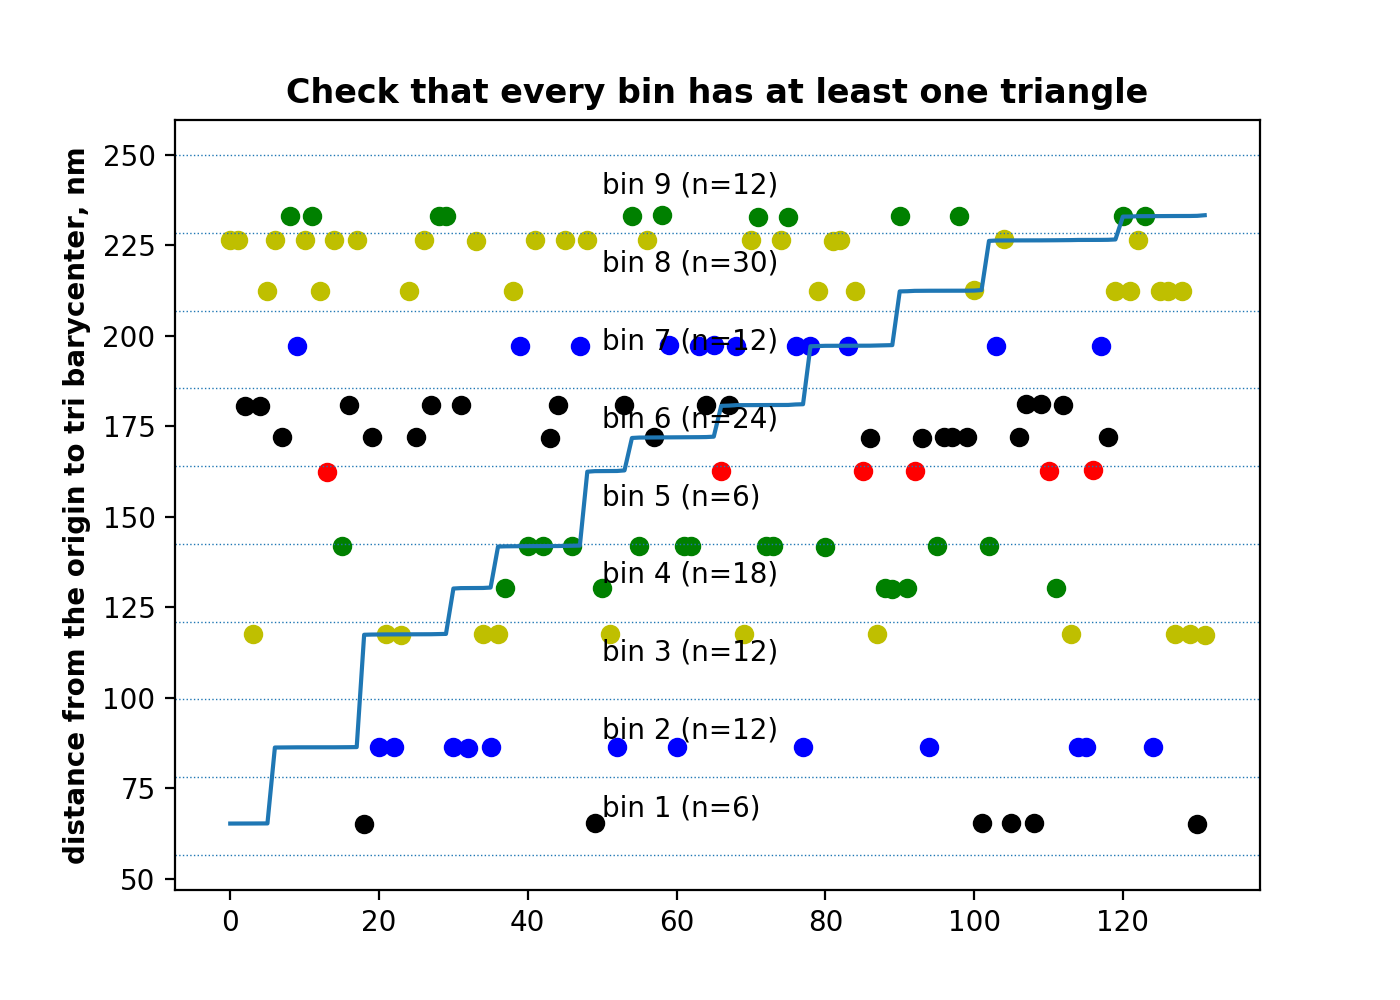

Text(0.5, 1.0, 'Check that every bin has at least one triangle')

In [6]:
%matplotlib notebook
fig = plt.figure(figsize=(7,5))
ax = fig.gca()

ax.plot(sorted(i[1]*1e9 for i in binnedAzTris))

c = ['k','b','y','g','r', 'k','b','y','g','r', 'k','b','y','g','r', 'k','b','y','g','r', 'k','b','y','g','r', 'k','b','y','g','r']
for i, tri in enumerate(binnedAzTris):
    ax.scatter(i, getP2Pdist(mesh.getTriBarycenter(tri[0]), cbaryc)*1e9, c=c[tri[2]-1])

for bin_edge in bin_edges:
    ax.axhline(bin_edge*1e9, linestyle=':', linewidth=0.5)
    
middists = [np.mean([i,j]) for i, j in zip(bin_edges[1:], bin_edges[:-1])]
for i_, middist in enumerate(middists):
    ax.annotate('bin {} (n={})'.format(i_ + 1, len([line[1]*1e9 for line in binnedAzTris if line[2]==(i_+1)])), (50, middist*1e9))


ax.set_ylabel('distance from the origin to tri barycenter, nm', weight='bold')
ax.set_title('Check that every bin has at least one triangle', weight='bold')
    
# # correct bins:
# nbins = len(set([i[2] for i in sorted(binnedAzTris, key=lambda x: x[2])]))

<IPython.core.display.Javascript object>


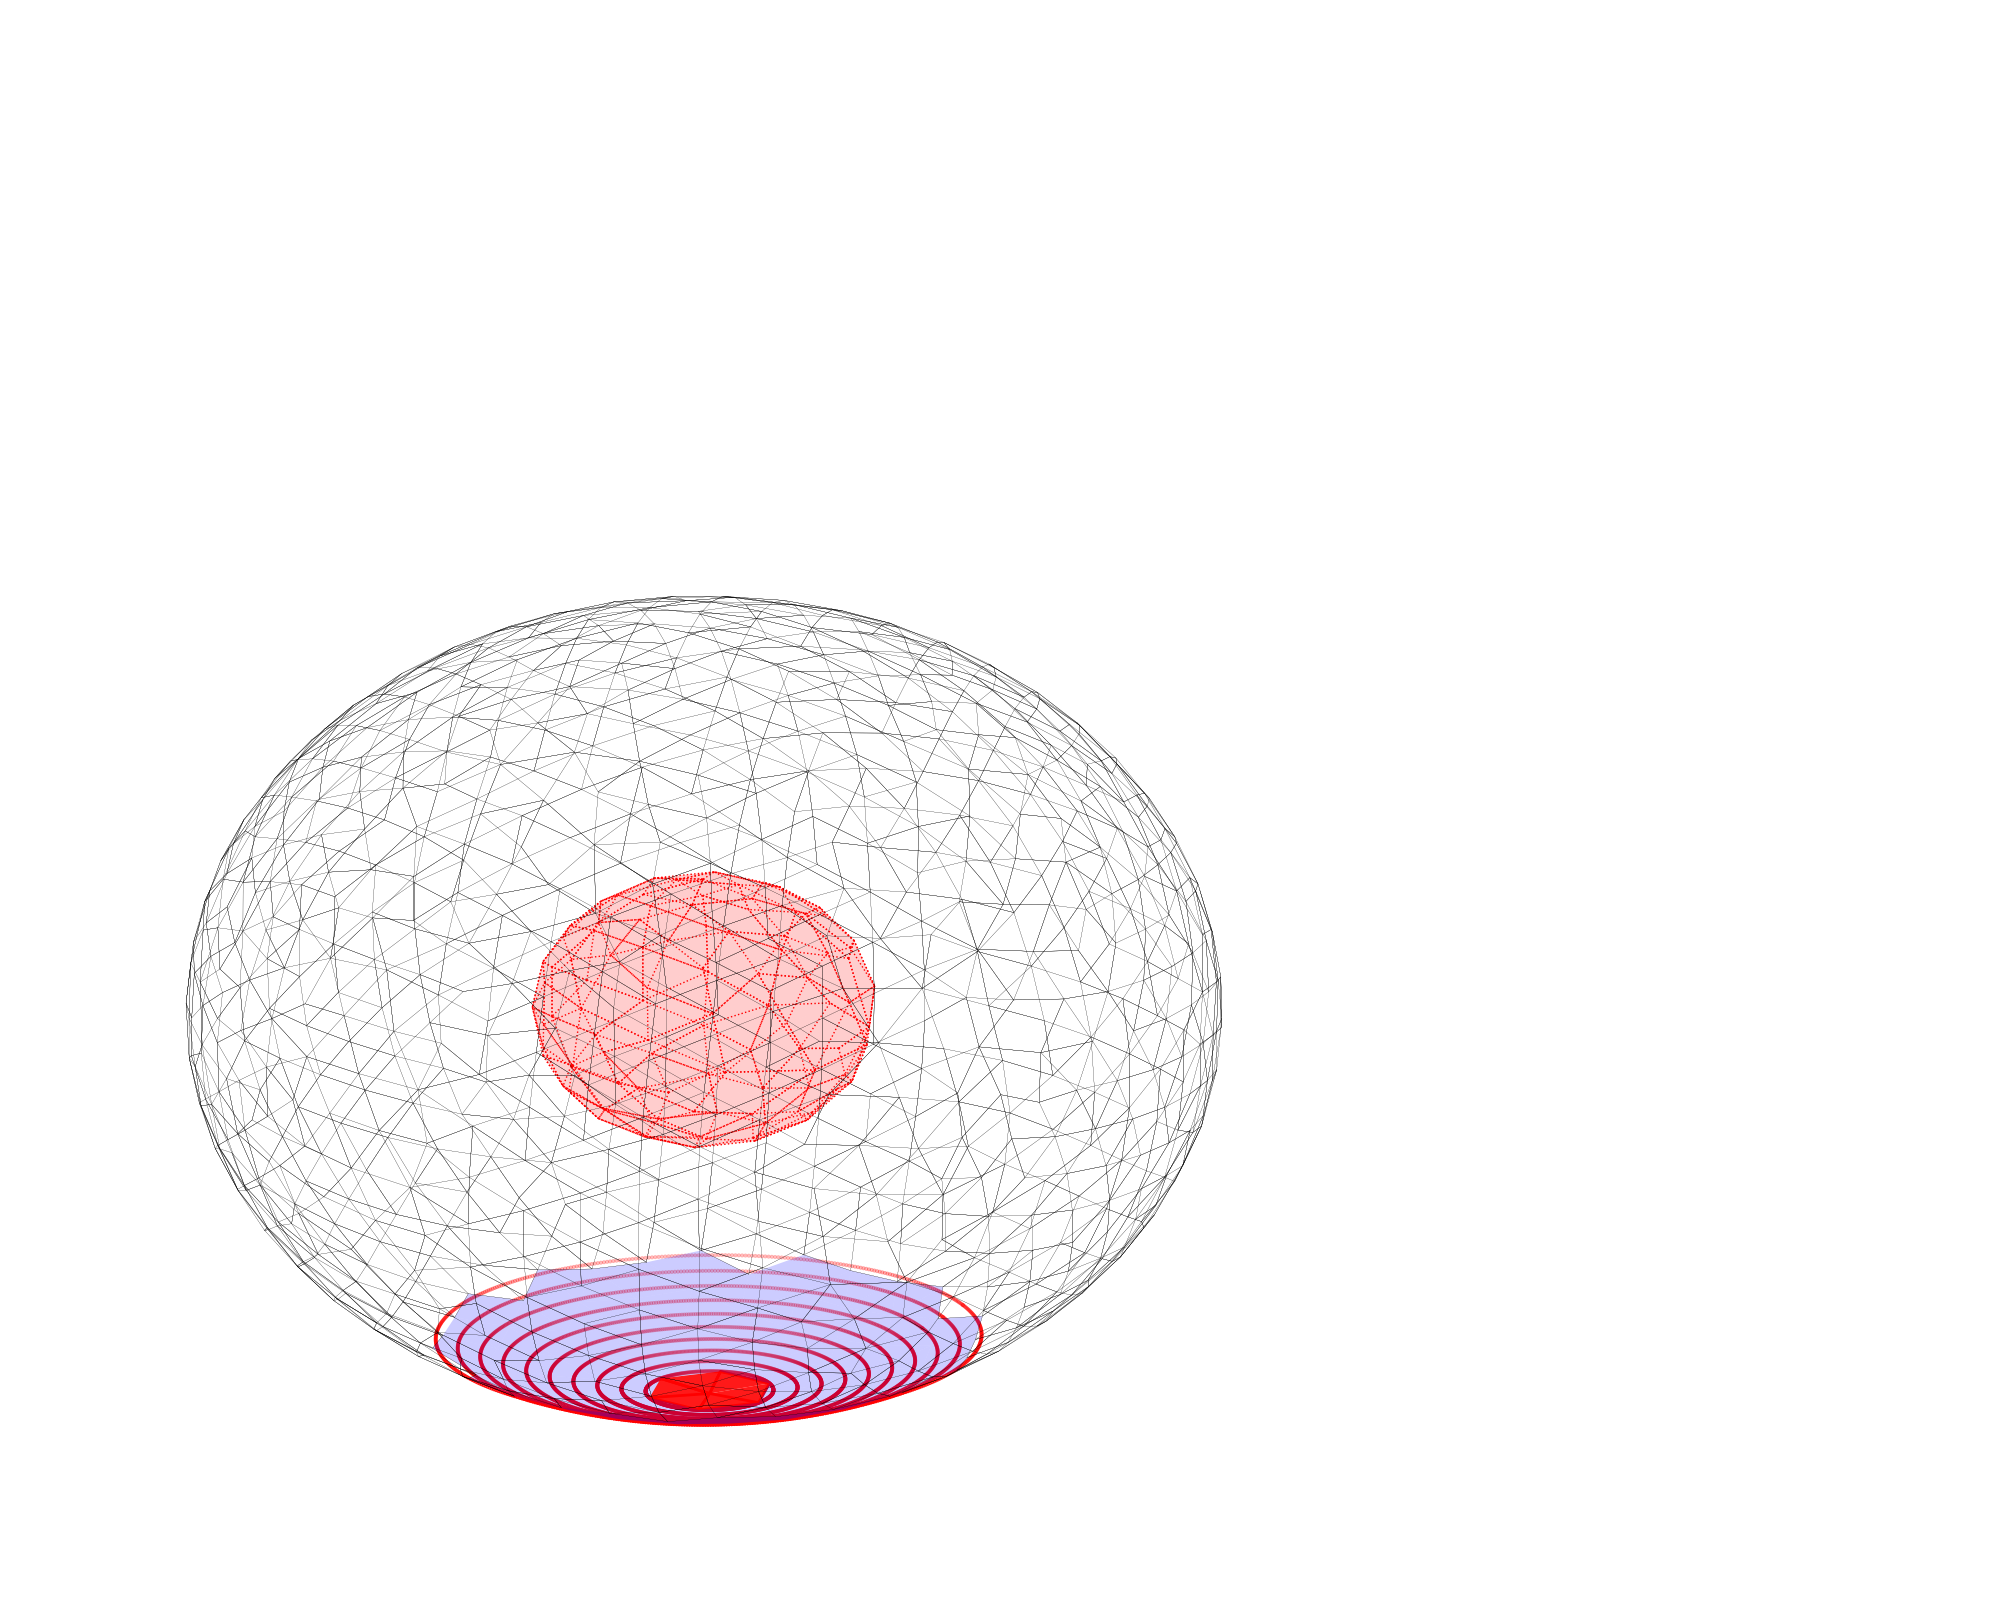

In [7]:
%matplotlib notebook

fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

# for bin_id in [i[2] for i in sorted(binnedAzTris, key=lambda x: x[2])]:  # has been FIXED FROM: in range(nbins-1)
#     chosenCaChTriId = getRndTriInDistBin(bin_id, binnedAzTris)
#     chosenCaChTriCoord = mesh.getTriBarycenter(chosenCaChTriId)
#     ax.scatter(*chosenCaChTriCoord, c='b')
#     ax.text(*chosenCaChTriCoord, bin_id)

# draw_polygon_coll(ax, mesh, cent_tets, sf=SCALING_FACTOR, pg=1, ln=1, c=[0,0,1], alpha=0.3, linewidths=0.5, linestyles=':')
draw_polygon_coll(ax, mesh, all_ER_tris, sf=SCALING_FACTOR, pg=1, ln=1, c=[1,0,0], alpha=0.1, linewidths=0.5, linestyles=':')
draw_polygon_coll(ax, mesh, NotCaSensTris, sf=SCALING_FACTOR, pg=1, ln=0, c=[0,0,1], alpha=0.2, linewidths=0.5, linestyles=':')
# draw_polygon_coll(ax, mesh, all_surf_tris, sf=SCALING_FACTOR, pg=0, ln=1, c=[0,1,0], alpha=0.1, linewidths=0.5, linestyles=':')
# draw_polygon_coll(ax, mesh, az_tet_tris, sf=SCALING_FACTOR, pg=0, ln=1, c=[1,0,1], alpha=0.9, linewidths=0.4, linestyles='-')
draw_polygon_coll(ax, mesh, CaSensTris, sf=SCALING_FACTOR, pg=1, ln=1, c=[1,0,0], alpha=0.9, linewidths=1, linestyles='-')
draw_polygon_coll(ax, mesh, NotAzTris, sf=SCALING_FACTOR, pg=0, ln=1, c=[0,0,0], alpha=0.4, linewidths=0.05, linestyles='-')

furthest_vertex = mesh.getVertex(furthest_vertex_id)
# ax.scatter(furthest_vertex[0], furthest_vertex[1], furthest_vertex[2], c='g', marker='d', s=30)
# ax.set_title('MESH FILE: {}'.format(meshfile), fontsize=16, color='red', fontweight='bold')

# ax.scatter(cbaryc[0], cbaryc[1], cbaryc[2], s=30, marker='d')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')

# Get rid of the panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Get rid of the spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Get rid of the ticks
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_zticks([])


for bin_edge in bin_edges:
    point = getEdgePoint(bin_edge, mesh)
#     ax.scatter(point[0], point[1], point[2], s=60, marker='d')
    plotCircleOnShereThruPoint(ax, point)

In [148]:
fig.savefig('mesh.svg', format='svg')

In [8]:
model = smodel.Model()

vsys0 = smodel.Volsys('vsys0', model) # cytosol
vsys1 = smodel.Volsys('vsys1', model) # ER

surfsys0 =  smodel.Surfsys('surfsys0', model) # cytosol membrane
surfsys2 =  smodel.Surfsys('surfsys2', model) # ER memb
ssys =      smodel.Surfsys('ssys', model)     # AZ


########## Initial Membrane Potential #########
init_pot = -60e-3

vrange = [-400.0e-3, 400e-3, 1e-4]

########## BULK RESISTIVITY ##########
Ra = 235.7*1.0e-2

# Calcium channel
Ca = smodel.Spec('Ca', model)
# Ca_Ch = smodel.Spec('Ca_Ch', model)
# Ca_sens = smodel.Spec('Ca_sens', model)
# Ca_sens_b = smodel.Spec('Ca_sens_b', model)

Ca.setValence(2)
Ca_oconc = 2e-3

# THE MODEL OF THE P-TYPE CA CHANNEL (AND ITS PARAMETERS COME FROM ANWAR, HONG, DE SCHUTTER 2012)

CaP_P = 0.5e-20      # permeability of a single channel (m3/s) HERE IS A PROBLEM (3.72 pS)
CaP_ro = 7 * 3.8e13  # density per square meter
# CaP_ro = float(sys.argv[3]) * 15.0 * 3.8e13  # density per square metera
estCaPcount = round(CaP_ro * NotCaSensTris_area)
print('Estimated number of channels in the AZ: {:.1f}'.format(estCaPcount))

CaPchan = smodel.Chan('CaPchan', model)
CaP_m0 = smodel.ChanState('CaP_m0', model, CaPchan)
CaP_m1 = smodel.ChanState('CaP_m1', model, CaPchan)
CaP_m2 = smodel.ChanState('CaP_m2', model, CaPchan)
CaP_m3 = smodel.ChanState('CaP_m3', model, CaPchan)

CaP_m0_p = 0.92402
CaP_m1_p = 0.073988
CaP_m2_p = 0.0019748
CaP_m3_p = 1.7569e-05

#Units (mV)
vhalfm = -29.458
cvm = 8.429

def minf_cap(V):
    #Units (mV)
    vhalfm = -29.458
    cvm = 8.429
    vshift = 0.0
    return (1.0/(1.0 + math.exp(-(V-vhalfm-vshift)/cvm)))

def tau_cap(V):
    vshift = 0.0
    if (V-vshift) >= -40:
        return (0.2702 + 1.1622 * math.exp(-(V+26.798-vshift)*(V+26.798-vshift)/164.19))
    else:
        return (0.6923 * math.exp((V-vshift)/1089.372))

def alpha_cap(V): # activation rate function
    return (minf_cap(V)/tau_cap(V))

def beta_cap(V):  # inactivation rate function
    return ((1.0-minf_cap(V))/tau_cap(V))


CaPm0m1 = smodel.VDepSReac('CaPm0m1', ssys, slhs = [CaP_m0], srhs = [CaP_m1], k= lambda V: 1.0e3 *3.* alpha_cap(V*1.0e3), vrange=vrange)
CaPm1m2 = smodel.VDepSReac('CaPm1m2', ssys, slhs = [CaP_m1], srhs = [CaP_m2], k= lambda V: 1.0e3 *2.* alpha_cap(V*1.0e3), vrange=vrange)
CaPm2m3 = smodel.VDepSReac('CaPm2m3', ssys, slhs = [CaP_m2], srhs = [CaP_m3], k= lambda V: 1.0e3 *1.* alpha_cap(V*1.0e3), vrange=vrange)

CaPm3m2 = smodel.VDepSReac('CaPm3m2', ssys, slhs = [CaP_m3], srhs = [CaP_m2], k= lambda V: 1.0e3 *3.* beta_cap(V*1.0e3), vrange=vrange)
CaPm2m1 = smodel.VDepSReac('CaPm2m1', ssys, slhs = [CaP_m2], srhs = [CaP_m1], k= lambda V: 1.0e3 *2.* beta_cap(V*1.0e3), vrange=vrange)
CaPm1m0 = smodel.VDepSReac('CaPm1m0', ssys, slhs = [CaP_m1], srhs = [CaP_m0], k= lambda V: 1.0e3 *1.* beta_cap(V*1.0e3), vrange=vrange)

# current that will start for channels in the n4 conformational state:
OC_CaP = smodel.GHKcurr('OC_CaP', ssys, CaP_m3, Ca, virtual_oconc = Ca_oconc, computeflux = True)

#Set single channel permeability
OC_CaP.setP(CaP_P)



diff_Ca_cyt  = smodel.Diff('diff_Ca_cyt',  vsys0,    Ca,         DCST) # name, where, what, how fast
diff_Ca_ER  = smodel.Diff('diff_Ca_ER',    vsys1,    Ca,         DCST) # name, where, what, how fast

# diff_Ca_sens    = smodel.Diff('diff_Ca_sens', surfsys2, Ca_sens,  DCST) # name, where, what, how fast

# define compartments:
cyto_comp = stetmesh.TmComp('cyto_comp', mesh, CS_tet_IDs)
ER_comp = stetmesh.TmComp('ER_comp', mesh, ER_tet_IDs)

# get surf tris in comps:
CS_memb_tris = meshctrl.findSurfTrisInComp(mesh, cyto_comp)
ER_memb_tris = meshctrl.findOverlapTris(mesh, CS_tet_IDs, ER_tet_IDs)

# patches:
ER_surf = stetmesh.TmPatch('ER_surf', mesh, ER_memb_tris, icomp=ER_comp, ocomp=cyto_comp)
memb_surf = stetmesh.TmPatch('memb_surf', mesh, NotAzTris, icomp=cyto_comp, ocomp=None)
# AZ_surf     = stetmesh.TmPatch('AZ_surf',         mesh, az_tris,     icomp = cyto_comp)

# $-----$-----$-----$-----$-----$-----$-----$-----$-----$-----$-----$-----
# Create the patch and associate with surface system 'ssys'
patch = stetmesh.TmPatch('patch', mesh, NotCaSensTris, icomp = cyto_comp)

# Create the membrane across which the potential will be solved
membrane = stetmesh.Memb('membrane', mesh, [patch], opt_method = 1)
# $-----$-----$-----$-----$-----$-----$-----$-----$-----$-----$-----$-----

# add volume systems (with all their reactions and diff rules) to compartments:
cyto_comp.addVolsys('vsys0')
ER_comp.addVolsys('vsys1')
memb_surf.addSurfsys('surfsys0')
ER_surf.addSurfsys('surfsys2')
# $-----$-----$-----$-----$-----$-----$-----$-----$-----$-----$-----$-----
patch.addSurfsys('ssys')
# $-----$-----$-----$-----$-----$-----$-----$-----$-----$-----$-----$-----





# Reactions involving SERCA:
# # SERCA species:
# SERCA_X0Ca = smodel.Spec('SERCA_X0Ca', model)
# SERCA_X1Ca = smodel.Spec('SERCA_X1Ca', model)
# SERCA_X2Ca = smodel.Spec('SERCA_X2Ca', model)
# SERCA_Y2Ca = smodel.Spec('SERCA_Y2Ca', model)
# SERCA_Y1Ca = smodel.Spec('SERCA_Y1Ca', model)
# SERCA_Y0Ca = smodel.Spec('SERCA_Y0Ca', model)

# # on- and off-rates for SERCA:
# kx0x1 = 2e9 # !!!!!!!!!
# kx1x0 = 83.7 
# kx1x2 = 1e9 # !!!!!!!!!
# kx2x1 = 167.4
# kx2y2 = 0.6
# ky2x2 = 0.097
# ky2y1 = 60.04
# ky1y2 = 1e5
# ky1y0 = 30.02
# ky0y1 = 2e5
# ky0x0 = 0.4
# kx0y0 = 1.2e-3
# # when SERCA faces outward (into the cytosol):
# ser_x0x1 = smodel.SReac('ser_x0x1', surfsys2, olhs=[Ca], slhs=[SERCA_X0Ca], srhs=[SERCA_X1Ca], kcst=kx0x1)
# ser_x1x0 = smodel.SReac('ser_x1x0', surfsys2, slhs=[SERCA_X1Ca], olhs=[Ca], srhs=[SERCA_X0Ca], kcst=kx1x0)
# ser_x1x2 = smodel.SReac('ser_x1x2', surfsys2, olhs=[Ca], slhs=[SERCA_X1Ca], srhs=[SERCA_X2Ca], kcst=kx1x2)
# ser_x2x1 = smodel.SReac('ser_x2x1', surfsys2, slhs=[SERCA_X2Ca], olhs=[Ca], srhs=[SERCA_X1Ca], kcst=kx2x1)

# # we change conformation from inward-facing to outward-facing:
# ser_x2y2 = smodel.SReac('ser_x2y2', surfsys2, slhs=[SERCA_X2Ca], srhs=[SERCA_Y2Ca],            kcst=kx2y2)
# ser_y2x2 = smodel.SReac('ser_y2x2', surfsys2, slhs=[SERCA_Y2Ca], srhs=[SERCA_X2Ca],            kcst=ky2x2)

# # when SERCA faces inward (into the ER):
# ser_y2y1 = smodel.SReac('ser_y2y1', surfsys2, slhs=[SERCA_Y2Ca], srhs=[SERCA_Y1Ca], irhs=[Ca], kcst=ky2y1)
# ser_y1y2 = smodel.SReac('ser_y1y2', surfsys2, ilhs=[Ca], slhs=[SERCA_Y1Ca], srhs=[SERCA_Y2Ca], kcst=ky1y2)
# ser_y1y0 = smodel.SReac('ser_y1y0', surfsys2, slhs=[SERCA_Y1Ca], srhs=[SERCA_Y0Ca], irhs=[Ca], kcst=ky1y0)
# ser_y0y1 = smodel.SReac('ser_y0y1', surfsys2, ilhs=[Ca], slhs=[SERCA_Y0Ca], srhs=[SERCA_Y1Ca], kcst=ky0y1)

# # we change conformation from outward-facing to inward-facing:
# ser_y0x0 = smodel.SReac('ser_y0x0', surfsys2, slhs=[SERCA_Y0Ca], srhs=[SERCA_X0Ca]           , kcst=ky0x0)
# ser_x0y0 = smodel.SReac('ser_x0y0', surfsys2, slhs=[SERCA_X0Ca], srhs=[SERCA_Y0Ca]           , kcst=kx0y0)

# ////////////////////////////////////////////////////////////////////////////////////////////////////////
# Ca + SERCA <->  Ca1SERCA +Ca <->  Ca2SERCA  ->  SERCA

DCST_MEM = 0.05e-12

SERCA = smodel.Spec('SERCA', model)
CaSERCA = smodel.Spec('CaSERCA',model)
Ca2SERCA = smodel.Spec('Ca2SERCA',model)

diff_SERCA = smodel.Diff('diff_SERCA', surfsys2, SERCA,  DCST_MEM)
diff_CaSERCA = smodel.Diff('diff_CaSERCA', surfsys2, CaSERCA,  DCST_MEM)
diff_Ca2SERCA = smodel.Diff('diff_Ca2SERCA', surfsys2, Ca2SERCA,  DCST_MEM)

Reac9  = smodel.SReac('Reac9',  surfsys2, olhs=[Ca], slhs=[SERCA], srhs=[CaSERCA], kcst=17147e6)
Reac10 = smodel.SReac('Reac10', surfsys2, slhs=[CaSERCA], orhs=[Ca], srhs=[SERCA], kcst=8426.3)
Reac11 = smodel.SReac('Reac11', surfsys2, olhs=[Ca], slhs=[CaSERCA], srhs=[Ca2SERCA], kcst=17147e6)
Reac12 = smodel.SReac('Reac12', surfsys2, slhs=[Ca2SERCA], orhs=[Ca], srhs=[CaSERCA], kcst=8426.3)
Reac13 = smodel.SReac('Reac13', surfsys2, slhs=[Ca2SERCA], srhs=[SERCA], irhs=[Ca,Ca], kcst=250)
# ////////////////////////////////////////////////////////////////////////////////////////////////////////

# PMCA species:
PMCA_P0 = smodel.Spec('PMCA_P0', model)
PMCA_P1 = smodel.Spec('PMCA_P1', model)

k1_pmca = 1.5e8
k2_pmca = 15
k3_pmca = 12
kl_pmca = 4.3


PMCA_P0P1 = smodel.SReac('PMCA_P0P1',       surfsys0, ilhs=[Ca], slhs=[PMCA_P0], srhs=[PMCA_P1], kcst=k1_pmca)
PMCA_P1P0 = smodel.SReac('PMCA_P1P0',       surfsys0, slhs=[PMCA_P1], srhs=[PMCA_P0], ilhs=[Ca], kcst=k2_pmca)
PMCA_P1P0ext = smodel.SReac('PMCA_P1P0ext', surfsys0, slhs=[PMCA_P1], srhs=[PMCA_P0],            kcst=k3_pmca)
PMCA_leak = smodel.SReac('PMCA_leak',       surfsys0, slhs=[PMCA_P0], srhs=[PMCA_P0], irhs=[Ca], kcst=kl_pmca)


# ////////////////////////////////////////////////////////////////////////////////////////////////////////
PV = smodel.Spec('PV', model) 
PV_Ca = smodel.Spec('PV_Ca', model)
PV_2Ca = smodel.Spec('PV_2Ca', model)

kreac_f_PV_Ca = smodel.Reac('kreac_f_PV_Ca', vsys0, lhs=[PV, Ca], rhs=[PV_Ca], kcst=107e6)
kreac_b_PV_Ca = smodel.Reac('kreac_b_PV_Ca', vsys0, lhs=[PV_Ca], rhs=[PV, Ca], kcst=0.95)

kreac_f_PV_2Ca = smodel.Reac('kreac_f_PV_2Ca', vsys0, lhs=[PV_Ca, Ca], rhs=[PV_2Ca], kcst=107e6)
kreac_b_PV_2Ca = smodel.Reac('kreac_b_PV_2Ca', vsys0, lhs=[PV_2Ca], rhs=[PV_Ca, Ca], kcst=0.95)

# ////////////////////////////////////////////////////////////////////////////////////////////////////////
CBhi = smodel.Spec('CBhi', model)         # CALBINDIN 1 (D-28K) (we consider the 2 (hi-aff) : 2 (lo-aff) scenario)
CBhi_Ca = smodel.Spec('CBhi_Ca', model)   # Binding Kinetics of Calbindin-D28k Determined by Flash Photolysis of Caged Ca2 (Nägerl 2000)
CBhi_2Ca = smodel.Spec('CBhi_2Ca', model)
CBlo = smodel.Spec('CBlo', model)
CBlo_Ca = smodel.Spec('CBlo_Ca', model)
CBlo_2Ca = smodel.Spec('CBlo_2Ca', model)


kreac_f_CBhi_Ca = smodel.Reac('kreac_f_CBhi_Ca', vsys0, lhs = [CBhi, Ca], rhs = [CBhi_Ca], kcst = 1.1e7)
kreac_b_CBhi_Ca = smodel.Reac('kreac_b_CBhi_Ca', vsys0, lhs = [CBhi_Ca], rhs = [CBhi, Ca], kcst = 2.607)

kreac_f_CBhi_2Ca = smodel.Reac('kreac_f_CBhi_2Ca', vsys0, lhs = [CBhi_Ca, Ca], rhs = [CBhi_2Ca], kcst = 1.1e7)
kreac_b_CBhi_2Ca = smodel.Reac('kreac_b_CBhi_2Ca', vsys0, lhs = [CBhi_2Ca], rhs = [CBhi_Ca, Ca], kcst = 2.607)

kreac_f_CBlo_Ca = smodel.Reac('kreac_f_CBlo_Ca', vsys0, lhs = [CBlo, Ca], rhs = [CBlo_Ca], kcst = 8.7e7)
kreac_b_CBlo_Ca = smodel.Reac('kreac_b_CBlo_Ca', vsys0, lhs = [CBlo_Ca], rhs = [CBlo, Ca], kcst = 35.76)

kreac_f_CBlo_2Ca = smodel.Reac('kreac_f_CBlo_2Ca', vsys0, lhs = [CBlo_Ca, Ca], rhs = [CBlo_2Ca], kcst = 8.7e7)
kreac_b_CBlo_2Ca = smodel.Reac('kreac_b_CBlo_2Ca', vsys0, lhs = [CBlo_2Ca], rhs = [CBlo_Ca, Ca], kcst = 35.76)


# ////////////////////////////////////////////////////////////////////////////////////////////////////////
Eggerman2002 = True

CaM_NtNt = smodel.Spec('CaM_NtNt', model)
CaM_NtNr = smodel.Spec('CaM_NtNr', model)
CaM_NrNr = smodel.Spec('CaM_NrNr', model)

CaM_CtCt = smodel.Spec('CaM_CtCt', model)
CaM_CtCr = smodel.Spec('CaM_CtCr', model)
CaM_CrCr = smodel.Spec('CaM_CrCr', model)

if Eggerman2002==True:
    KonT_N  = 7.7e8
    KoffT_N = 1.6e5
    KonR_N  = 3.2e10
    KoffR_N = 2.2e4

    KonT_C  = 8.4e7
    KoffT_C = 2.6e3
    KonR_C  = 2.5e7
    KoffR_C = 6.5
else:
    KonT_N  = 8.9e8
    KoffT_N = 5.2e5
    KonR_N  = 10.5e10
    KoffR_N = 4.3e4

    KonT_C  = 7.9e7
    KoffT_C = 3.4e3
    KonR_C  = 7.4e7
    KoffR_C = 1.2


kreac_f_CaM_NtNt = smodel.Reac('kreac_f_CaM_NtNt', vsys0, lhs = [CaM_NtNt, Ca], rhs = [CaM_NtNr], kcst = 2 * KonT_N)
kreac_b_CaM_NtNt = smodel.Reac('kreac_b_CaM_NtNt', vsys0, lhs = [CaM_NtNr], rhs = [CaM_NtNt, Ca], kcst = KoffT_N)

kreac_f_CaM_NrNr = smodel.Reac('kreac_f_CaM_NrNr', vsys0, lhs = [CaM_NtNr, Ca], rhs = [CaM_NrNr], kcst = KonR_N)
kreac_b_CaM_NrNr = smodel.Reac('kreac_b_CaM_NrNr', vsys0, lhs = [CaM_NrNr], rhs = [CaM_NtNr, Ca], kcst = 2 * KoffR_N)

kreac_f_CaM_CtCt = smodel.Reac('kreac_f_CaM_CtCt', vsys0, lhs = [CaM_CtCt, Ca], rhs = [CaM_CtCr], kcst = 2 * KonT_C)
kreac_b_CaM_CtCt = smodel.Reac('kreac_b_CaM_CtCt', vsys0, lhs = [CaM_CtCr], rhs = [CaM_CtCt, Ca], kcst = KoffT_C)

kreac_f_CaM_CrCr = smodel.Reac('kreac_f_CaM_CrCr', vsys0, lhs = [CaM_CtCr, Ca], rhs = [CaM_CrCr], kcst = KonR_C)
kreac_b_CaM_CrCr = smodel.Reac('kreac_b_CaM_CrCr', vsys0, lhs = [CaM_CrCr], rhs = [CaM_CtCr, Ca], kcst = 2 * KoffR_C)





# ////////////////////////////////////////////////////////////////////////////////////////////////////////
CRTT     = smodel.Spec('CRTT', model)     # pairs of cooperative binding sites MULTIPLY BY TWO to get 4
CRTR_Ca  = smodel.Spec('CRTR_Ca', model)
CRRR_2Ca = smodel.Spec('CRRR_2Ca', model)
CRind     = smodel.Spec('CRind', model)
CRind_Ca  = smodel.Spec('CRind_Ca', model) # independent binding site

kon_T  = 1.8e6
koff_T = 53
kon_R  = 3.1e8
koff_R = 20
kon_ind  = 7.3e6
koff_ind = 252

# pair 1 (you MUST multiply its concentration by 2) because WE'VE GOT TWO PAIRS OF COOPERATIVE CA2+ BINDING SITES
kreac_f_CRTT1_Ca = smodel.Reac('kreac_f_CRTT1_Ca', vsys0, lhs = [CRTT, Ca], rhs = [CRTR_Ca], kcst=2*kon_T) # two domains are free, so we multiply the association rate by 2
kreac_b_CRTT1_Ca = smodel.Reac('kreac_b_CRTT1_Ca', vsys0, lhs = [CRTR_Ca], rhs = [CRTT, Ca], kcst=koff_T)
kreac_f_CRRR1_2Ca = smodel.Reac('kreac_f_CRRR1_2Ca', vsys0, lhs = [CRTR_Ca, Ca], rhs = [CRRR_2Ca], kcst=kon_T) 
kreac_b_CRRR1_2Ca = smodel.Reac('kreac_b_CRRR1_2Ca', vsys0, lhs = [CRRR_2Ca], rhs = [CRTR_Ca, Ca], kcst = 2*koff_R) # two domains are occupied, so we multiply the dissociation rate by 2

# independent Ca2+ binding site:
kreac_f_CRind_Ca = smodel.Reac('kreac_f_CRind_Ca', vsys0, lhs = [CRind, Ca], rhs = [CRind_Ca], kcst=kon_ind)
kreac_b_CRind_Ca = smodel.Reac('kreac_b_CRind_Ca', vsys0, lhs = [CRind_Ca], rhs = [CRind, Ca], kcst=koff_ind)


Estimated number of channels in the AZ: 47.0


In [9]:
CytoCompSpecs = ['Ca', 'CRTT', 'CRTR_Ca', 'CRRR_2Ca', 'CRind', 'CRind_Ca', 'CaM_NtNt', 'CaM_NtNr', 'CaM_NrNr', 'CaM_CtCt', 'CaM_CtCr', 'CaM_CrCr', 'CBhi', 'CBlo', 'CBhi_Ca', 'CBhi_2Ca', 'CBlo_Ca', 'CBlo_2Ca', 'PV', 'PV_Ca', 'PV_2Ca']
a = list(zip(CytoCompSpecs, ['cyto_comp'] * len(CytoCompSpecs), ['comp'] * len(CytoCompSpecs)))
AzPatchSpecs = ['CaP_m0', 'CaP_m1', 'CaP_m2', 'CaP_m3']
b = list(zip(AzPatchSpecs, ['patch'] * len(AzPatchSpecs), ['patch'] * len(AzPatchSpecs)))
ErSurfSpecs = ['SERCA', 'CaSERCA', 'Ca2SERCA']
c = list(zip(ErSurfSpecs, ['ER_surf'] * len(ErSurfSpecs), ['patch'] * len(ErSurfSpecs)))
ErCompSpecs = ['Ca']
d = list(zip(ErCompSpecs, ['ER_comp'] * len(ErCompSpecs), ['comp'] * len(ErCompSpecs)))
membSurfSpecs = ['PMCA_P0', 'PMCA_P1']
e = list(zip(membSurfSpecs, ['memb_surf'] * len(membSurfSpecs), ['patch'] * len(membSurfSpecs)))
specs = a + b + c + d + e
specs

[('Ca', 'cyto_comp', 'comp'),
 ('CRTT', 'cyto_comp', 'comp'),
 ('CRTR_Ca', 'cyto_comp', 'comp'),
 ('CRRR_2Ca', 'cyto_comp', 'comp'),
 ('CRind', 'cyto_comp', 'comp'),
 ('CRind_Ca', 'cyto_comp', 'comp'),
 ('CaM_NtNt', 'cyto_comp', 'comp'),
 ('CaM_NtNr', 'cyto_comp', 'comp'),
 ('CaM_NrNr', 'cyto_comp', 'comp'),
 ('CaM_CtCt', 'cyto_comp', 'comp'),
 ('CaM_CtCr', 'cyto_comp', 'comp'),
 ('CaM_CrCr', 'cyto_comp', 'comp'),
 ('CBhi', 'cyto_comp', 'comp'),
 ('CBlo', 'cyto_comp', 'comp'),
 ('CBhi_Ca', 'cyto_comp', 'comp'),
 ('CBhi_2Ca', 'cyto_comp', 'comp'),
 ('CBlo_Ca', 'cyto_comp', 'comp'),
 ('CBlo_2Ca', 'cyto_comp', 'comp'),
 ('PV', 'cyto_comp', 'comp'),
 ('PV_Ca', 'cyto_comp', 'comp'),
 ('PV_2Ca', 'cyto_comp', 'comp'),
 ('CaP_m0', 'patch', 'patch'),
 ('CaP_m1', 'patch', 'patch'),
 ('CaP_m2', 'patch', 'patch'),
 ('CaP_m3', 'patch', 'patch'),
 ('SERCA', 'ER_surf', 'patch'),
 ('CaSERCA', 'ER_surf', 'patch'),
 ('Ca2SERCA', 'ER_surf', 'patch'),
 ('Ca', 'ER_comp', 'comp'),
 ('PMCA_P0', 'memb_surf', 

In [10]:
# Print geom stats:

cyt_vol = 0;
for tets in CS_tet_IDs:
    cyt_vol += mesh.getTetVol(tets)
print ("Cytosol volume =\t", cyt_vol)

cyt_memb_area = 0;
for tri in CS_memb_tris:
    cyt_memb_area += mesh.getTriArea(tri)
print ("Cytosol memb. area =\t", cyt_memb_area)

cyt_vol = 0;
for tets in ER_tet_IDs:
    cyt_vol += mesh.getTetVol(tets)
print ("Endoplasmic R. volume =\t", cyt_vol)

ER_memb_area = 0;
for tri in ER_memb_tris:
    ER_memb_area += mesh.getTriArea(tri)
print ("Endoplasmic R. area =\t", ER_memb_area)

Cytosol volume =	 3.661275331387929e-19
Cytosol memb. area =	 2.536400122576593e-12
Endoplasmic R. volume =	 1.3332059130642968e-20
Endoplasmic R. area =	 2.7383443401339504e-13


In [11]:
def ResetSim (sim, model, mesh, rng, bin_id):
    SERCA_ro =      1000*1e12 # Bartol 2015. Computational reconstitution...
    init_memb_pot = -60e-3
    memb_cap =      1.0e-2
    memb_resist =   1.0
    
    sim.reset()

    # total CB in rat HC: 1.98e-6
    sim.setCompConc('cyto_comp', 'CBhi', 0.99e-6) # i.e. 1/2 of total CB molarity (1.98*10e-6)
    sim.setCompConc('cyto_comp', 'CBlo', 0.99e-6) # i.e. 1/2 of total CB molarity (1.98*10e-6)

    # total CaM in rat HC: 57.82e-6
    sim.setCompConc('cyto_comp', 'CaM_NtNt', 0.5 * 57.82e-6) # i.e. 1/2 of total CaM molarity
    sim.setCompConc('cyto_comp', 'CaM_CtCt', 0.5 * 57.82e-6) # i.e. 1/2 of total CaM molarity

    # total CR in rat HC: 2.47e-6
    # WE MODEL TWO IDENTICAL PAIRS OF COOPERATIVE BINDING SITES AS ONE SPECIES.
    # SO WE SET ITS CONCENTRATION TO 4/5 OF THE TOTAL CONCENTRATION OF CR. THE REMAINING 1/5 IS THE INDEPENDENT SITE/
    sim.setCompConc('cyto_comp', 'CRTT', 0.1976e-6)   # 4/5 of total CR concentration (2 pairs of cooperative sites)
    sim.setCompConc('cyto_comp', 'CRind', 0.494e-6)  # 1/5 of total CR
    
    # total PV in rat HC: 4.55e-6
    sim.setCompConc('cyto_comp', 'PV', 4.55e-6)

    SERCA_count = sim.getPatchArea('ER_surf') * SERCA_ro
    sim.setPatchCount('ER_surf', 'SERCA', SERCA_count)
    sim.setPatchCount('memb_surf', 'PMCA_P0', round(sim.getPatchArea('memb_surf')*1e12 * 180)) # Nadkarni 2010
#     sim.setPatchCount('memb_surf', 'NCX_P0', 11)    
    
    print(bin_id)
    chosenCaChTriId = getRndTriInDistBin(bin_id, binnedAzTris)
    surfarea = sim.getPatchArea('patch')
    sim.setTriCount(chosenCaChTriId, 'CaP_m0', round(CaP_ro*surfarea*CaP_m0_p))  # !!!!!!!!!!!!!! @@@@@@@@
    sim.setTriCount(chosenCaChTriId, 'CaP_m1', round(CaP_ro*surfarea*CaP_m1_p))
    sim.setTriCount(chosenCaChTriId, 'CaP_m2', round(CaP_ro*surfarea*CaP_m2_p))
    sim.setTriCount(chosenCaChTriId, 'CaP_m3', round(CaP_ro*surfarea*CaP_m3_p))
    print('chosenCaChTriId: {}'.format(chosenCaChTriId))

    # Set dt for membrane potential calculation to 0.01ms
    sim.setEfieldDT(0.0003)

    # Initialise potential to -65mV
    sim.setMembPotential('membrane', init_memb_pot)

    # Set capacitance of the membrane to 1 uF/cm^2 = 0.01 F/m^2
    sim.setMembCapac('membrane', memb_cap)

    # Set resistivity of the conduction volume to 100 ohm.cm = 1 ohm.meter
    sim.setMembVolRes('membrane', memb_resist)
    
    return sim

def getAmpVolt(sim, NotCaSensTris):
    I, V = [], []
    for i in NotCaSensTris:
        I.append(sim.getTriGHKI(i, 'OC_CaP'))
        V = [sim.getTriV(i) for i in NotCaSensTris]
    return sum(I), np.mean(V)

def set_clamp_current(sim, Iclamp, furthest_vertex_id):
    sim.setVertIClamp(furthest_vertex_id, Iclamp)
    return sim

In [12]:
# the sim is best run on a cluster:

In [13]:
ZOOMING_ON_ONE_BIN = True # if False, the script will do one sim in each distbin and one VDCC number

CA_FLUX_ONSET =  0.020
CA_FLUX_OFFSET = 0.021
CA_FLUSH =       0.030
DT = 0.0003               # The data collection time increment (s)
T = 0.04                  # The simulation endtime (s)

dist_bin_ids = list(set([i[2] for i in binnedAzTris]))
tpnts = numpy.arange(0.0, T, DT)
ntpnts = tpnts.shape[0]
if ZOOMING_ON_ONE_BIN:
    NITER = 4
    dist_bin_ids = [dist_bin_ids[-1]] * NITER
    res = np.zeros((NITER, len(specs)+3, ntpnts))
else:
    NITER = nbins             # The number of iterations to run (NUMBER OF DISTANCES WE WANT TO TEST, SEE BELOW COMMENTS)
    res = np.zeros((NITER, len(specs)+3, ntpnts))

OC_CaP.setP(CaP_P)        # Set single channel permeability

rng = srng.create('mt19937', 512)
rng.initialize(np.random.randint(3000))

sim = solvmod.Tetexact(model, mesh, rng, True)
pbarlen = 50              # initialize a progressbar:

i = -1
for dist_bin_id in dist_bin_ids: # if you only want to zoom on one distbin
    ttime = time.time()
    i += 1
    sim = ResetSim(sim, model, mesh, rng, dist_bin_id)
    printProgressBar(0, NITER, prefix = 'Progress:', suffix = 'Complete', length = pbarlen)
    for j in range(ntpnts):        
        if tpnts[j] > CA_FLUX_ONSET and tpnts[j] < CA_FLUX_OFFSET:
            # depolarize the membrane at time (CA_FLUX_ONSET, CA_FLUX_OFFSET)
            sim.setMembPotential('membrane', 25e-3)
#             set_clamp_current(sim, 10e-14, furthest_vertex_id)
#             note = colored('CLAMPING', 'red')
            note = 'CLAMPING'
        else:
#             set_clamp_current(sim, 0.0, furthest_vertex_id)
            sim.setMembPotential('membrane', -60e-3)
#             note = colored('NOT clamping', 'blue')
            note = 'NOT CLAMPING'
        if tpnts[j] > CA_FLUSH:
#             sim.setCompCount('cyto_comp', 'Ca', 0)
#             note = colored('Ca removed', 'green')
            note = 'Ca removed'
        sim.run(tpnts[j])
        
        for spec_id in range(len(specs)):
            if specs[spec_id][2]=='comp':
                # res: [iteration x species x timepoints]
                res[i,spec_id,j] = sim.getCompCount(specs[spec_id][1], specs[spec_id][0])
            else:
                res[i,spec_id,j] = sim.getPatchCount(specs[spec_id][1], specs[spec_id][0])
        I, V = getAmpVolt(sim, NotCaSensTris)
        CaSensCount = sum([sim.getTetCount(tet, 'Ca') for tet in CaSensTets])
        res[i,len(specs),j] = I
        res[i,len(specs)+1,j] = V
        res[i,len(specs)+2,j] = CaSensCount
        
        printProgressBar(j + 1, ntpnts, prefix='Progress:', suffix='Complete \t' + note, length=pbarlen)
    time_per_one_bin = time.time() - ttime
    with open('timing.txt', 'a') as f:
        f.write('Bin: {}, time: {}'.format(i, time_per_one_bin))

9
chosenCaChTriId: 17606
Progress: |█-------------------------------------------------| 2.2% Complete 	NOT CLAMPING

KeyboardInterrupt: 

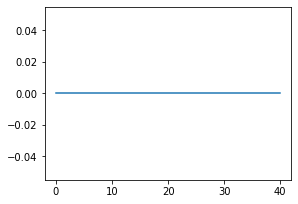

In [14]:
%matplotlib inline
plt.figure(figsize=(15,7))
plt.subplot(2,3,1)
plt.plot(tpnts*1e3, np.mean(res[:,-1,:], axis=0))
# plt.title('VDCCs: {:.0f}'.format(sum([sim.getPatchCount('patch', i) for i in ['CaP_m0', 'CaP_m1', 'CaP_m2', 'CaP_m3']])))

NameError: name 'count2umPL' is not defined

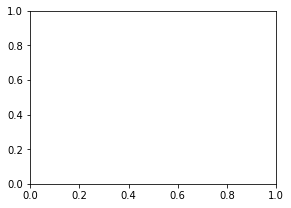

In [15]:
%matplotlib inline
if ZOOMING_ON_ONE_BIN:    
    plt.figure(figsize=(15,7))
    plt.subplot(2,3,1)
    volCaSensTetsInCubicM = sum([mesh.getTetVol(i) for i in CaSensTets])
    conc_uM = count2umPL(np.mean(res[:,31,:], axis=0), volCaSensTetsInCubicM)
    plt.plot(tpnts*1e3, conc_uM)
    plt.title('VDCCs: {:.0f}'.format(sum([sim.getPatchCount('patch', i) for i in ['CaP_m0', 'CaP_m1', 'CaP_m2', 'CaP_m3']])))

<IPython.core.display.Javascript object>


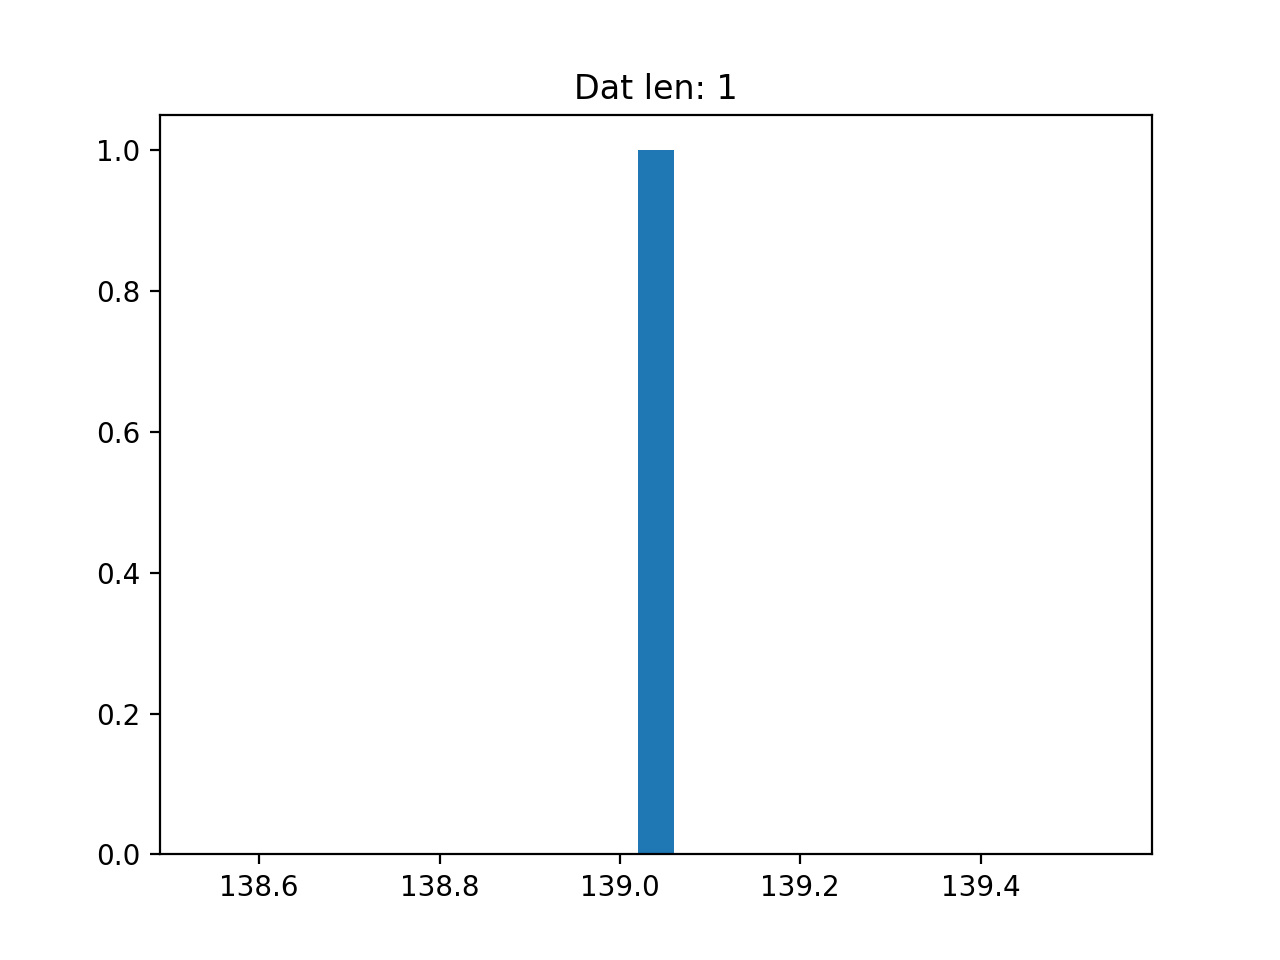

Text(0.5, 1.0, 'Dat len: 1')

In [329]:
x = []
with open('timing.txt', 'r') as f:
    x = f.readlines()

dat = []
for line in x:
    try:
        dat.append(float(line.split()[3][:6]))
    except:
        continue
plt.figure()
plt.hist(dat, 25)
plt.title('Dat len: {}'.format(len(dat)))

In [16]:
%matplotlib inline
M = []
plt.figure(figsize=(15,3))
for dist_bin in range(nbins-1):
    plt.plot(tpnts, np.mean(res[dist_bin,:,-1,:].squeeze(), axis=0), label='{:.3f} $\mu m$'.format(D_m[dist_bin]/SCALING_FACTOR))
    M.append(max(np.mean(res[dist_bin,:,-1,:].squeeze(), axis=0)))
plt.title('Ca count in Sensor tets over time (averaged over multiple realizations)', fontweight='bold')
plt.legend(title='Avg. dist CaSens-CaCh Clust.', loc='best', ncol=3)

plt.figure(figsize=(15,3))
plt.plot(tpnts, np.mean(res[dist_bin,:,-2,:].squeeze(), axis=0), label='{} in {}'.format('Voltage', 'membrane'))
plt.title('Membrand voltage (averaged over multiple realizations)', fontweight='bold')

IndexError: too many indices for array

<Figure size 1080x216 with 0 Axes>

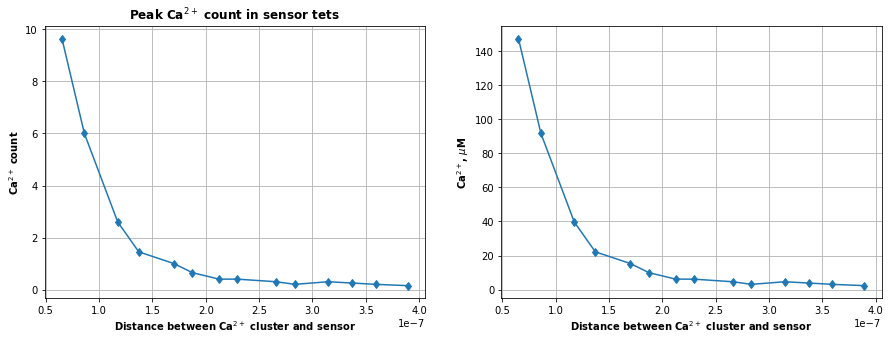

In [24]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(D_m, M, marker='d')
plt.grid()
plt.title('Peak Ca$^{2+}$ count in sensor tets', fontweight='bold')
plt.ylabel('Ca$^{2+}$ count', fontweight='bold')
plt.xlabel('Distance between Ca$^{2+}$ cluster and sensor', fontweight='bold')

plt.subplot(1,2,2)
from scipy.constants import N_A
moles = [i/N_A for i in M]
volCaSensTetsInCubicM = sum([mesh.getTetVol(i) for i in CaSensTets])
molesPerCubicMeter = [i/volCaSensTetsInCubicM for i in moles]
molesPerLiter = [i*0.001 for i in molesPerCubicMeter]
molesPerLiter
microMolesPerLiter = [i * 1e6 for i in molesPerLiter]
# ['{:.3f} uM/L'.format(i) for i in microMolesPerLiter]
plt.plot(D_m, microMolesPerLiter, marker='d')

plt.ylabel('Ca$^{2+}$, $\mu$M', fontweight='bold')
plt.xlabel('Distance between Ca$^{2+}$ cluster and sensor', fontweight='bold')
plt.grid()

to go from molecules to moles, divide N by Avogadro's number

# the cells below load and visualize results computed on the cluster

In [169]:
tab = []
for i, fname in enumerate(os.listdir('./dump2/')): # dump2 with PMCA, dump w/o PMCA
    tab.append([i] + fname.split('_'))

arrayids = []

CaConcs = []
for i in tab:
    arrayids.append(i[4])
    CaConcs.append(i[6])

arrayids = sorted(set(arrayids))
CaConcs = sorted(set(CaConcs))
print('Sims:\n', arrayids)
print('VDCC Counts (unsorted):\n', CaConcs)

Sims:
 ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '5', '6', '7', '8', '9']
VDCC Counts (unsorted):
 ['100', '110', '12', '120', '130', '140', '149', '159', '169', '179', '188', '198', '2', '208', '218', '22', '228', '237', '32', '42', '51', '61', '71', '81', '90']


In [170]:
TMP2 = []
VDCC_counts_sorted = np.sort(np.array(list(set(CaConcs)), dtype='int')).astype('str').tolist()
for i in VDCC_counts_sorted:
    TMP = []
    for line in tab:
        if line[6]==i:
            fname = '_'.join(line[1:])
#             print(i, fname)
#             print(fname)
            with open('dump2/' + fname, 'rb') as f:
                fdat = pickle.load(f)
                TMP.append(fdat['data'])
    TMP2.append(np.stack(TMP))
res = np.stack(TMP2)

res = res.transpose(1,0,2,3,4)
print(res.shape, '\tSHAPE: sims, CaConcs, distbins, specs, times')

res_avg = np.mean(res, axis=0) # SHAPE: CaConc, dist, specs, time   
print(res_avg.shape, '\tSHAPE: CaConcs, distbins, specs, times')

(40, 25, 9, 34, 134) 	SHAPE: sims, CaConcs, distbins, specs, times
(25, 9, 34, 134) 	SHAPE: CaConcs, distbins, specs, times


Text(0.5, 1.0, 'Ca count in Sensor tets over time (averaged over multiple realizations)\nas a function of VDCC number')

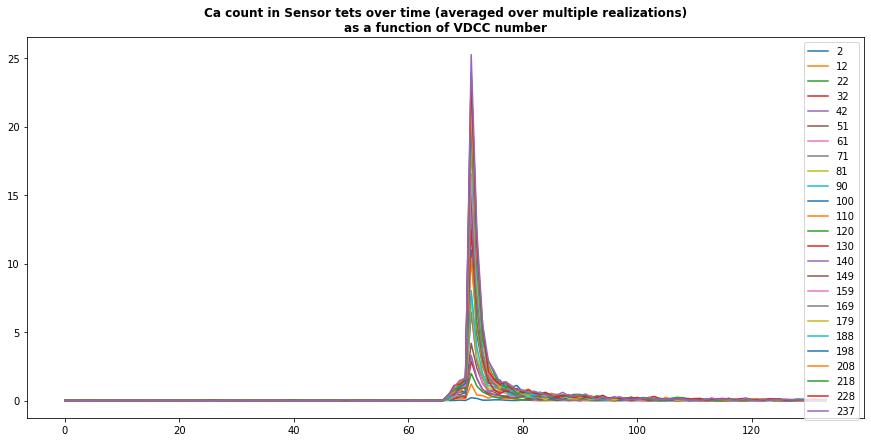

In [171]:
%matplotlib inline
plt.figure(figsize=(15,7))
for i, VDCC_count in enumerate(VDCC_counts_sorted):
    plt.plot(res_avg[i,0,-1,:], label=VDCC_count)
plt.legend()
plt.title('Ca count in Sensor tets over time (averaged over multiple realizations)\nas a function of VDCC number', fontweight='bold')

Text(0.5, 1.0, 'Ca count in Sensor tets over time (averaged over multiple realizations)\nas a function of VDCC distance from the Ca sensor')

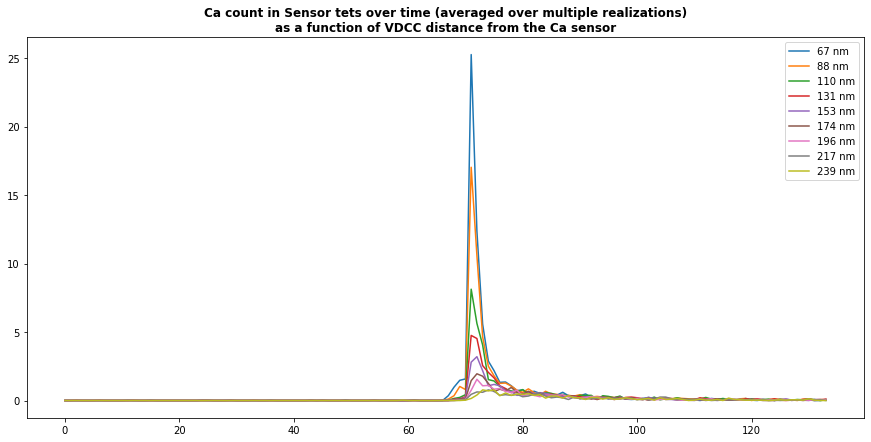

In [172]:
%matplotlib inline
plt.figure(figsize=(15,7))
for i, dist in enumerate(middists):
    plt.plot(res_avg[-1,i,-1,:], label='{} nm'.format(int(dist*1e9)))
plt.legend()
plt.title('Ca count in Sensor tets over time (averaged over multiple realizations)\nas a function of VDCC distance from the Ca sensor', fontweight='bold')

In [173]:
def count2umPL(count, volm3):
    from scipy.constants import N_A
    moles = count/N_A     
    molesPerCubicMeter = moles/volm3
    microMolesPerLiter = molesPerCubicMeter*1e-3*1e6
    return microMolesPerLiter

def findIdxOfClosest(list_of_vals, needed_val):
    list_of_vals = np.array(list_of_vals, dtype='float')
    d = np.abs(list_of_vals - needed_val)
    return np.argmin(d)
    

In [174]:
ddd = []
for i in NotCaSensTris:
    ddd.append(getP2Pdist(mesh.getTriBarycenter(i), cbaryc)*1e9)
print('Closest surface CaSensTri to origin: {:.1f} (nm)'.format(getP2Pdist(
    mesh.getTriBarycenter(CaSensTris[0]), cbaryc)*1e9))
print('Closest surface tri that is not in the sensor: {:.1f} (nm)'.format(min(ddd)))

Closest surface CaSensTri to origin: 32.6 (nm)
Closest surface tri that is not in the sensor: 65.2 (nm)


In [175]:
specid = [i for i, spec in enumerate(specs) if spec[0]=='CaP_m0']
specid

[21]

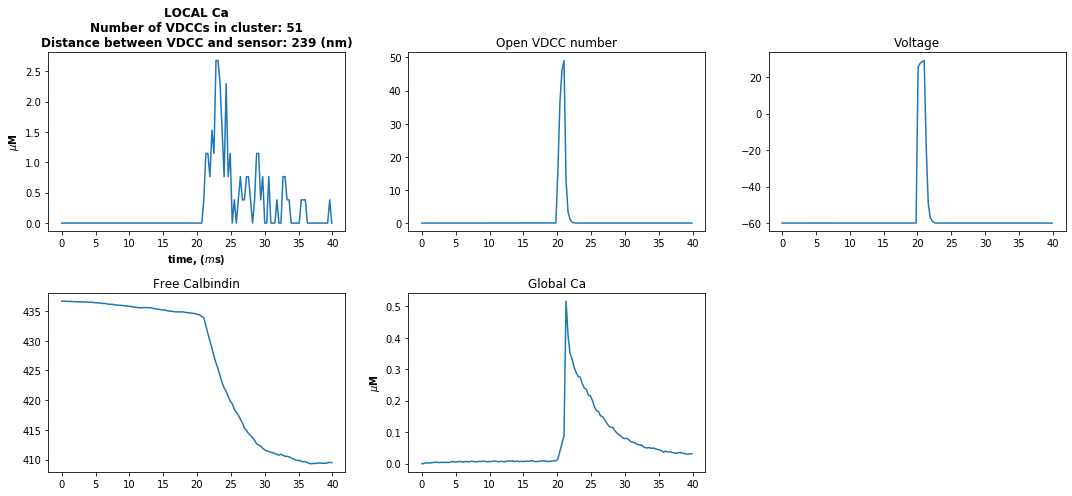

In [176]:
%matplotlib inline
from scipy.constants import N_A
middists_nm = fdat['bin_middists']

# middists_nm = [6.725503155184174e-08, 8.875443960456624e-08, 1.1025384765729074e-07, 1.3175325571001526e-07, 1.5325266376273972e-07, 1.7475207181546424e-07, 1.9625147986818875e-07, 2.1775088792091324e-07, 2.3925029597363773e-07]
distance_id = findIdxOfClosest([i*1e9 for i in middists_nm], 250)
conc_id = findIdxOfClosest(VDCC_counts_sorted, 48)

tit1 = 'Number of VDCCs in cluster: {}'.format(VDCC_counts_sorted[conc_id])
tit2 = 'Distance between VDCC and sensor: {:.0f} (nm)'.format(middists_nm[distance_id]*1e9)

fig = plt.figure(figsize=(15,7))

plt.subplot(2,3,1)
Ca_n = res_avg[conc_id, distance_id, -1, :]
volCaSensTetsInCubicM = sum([mesh.getTetVol(i) for i in CaSensTets])
conc_uM = count2umPL(Ca_n, volCaSensTetsInCubicM)
plt.plot(tpnts*1e3, conc_uM)
plt.ylabel('$\mu$M', weight='bold')
plt.xlabel('time, ($m$s)', weight='bold')
plt.title('LOCAL Ca\n'+ tit1 + '\n' + tit2, weight='bold')

plt.subplot(2,3,2)
specid = [i for i, spec in enumerate(specs) if spec[0]=='CaP_m3'][0]
plt.plot(tpnts*1e3, res_avg[conc_id, distance_id, specid, :])
plt.title('Open VDCC number')
plt.subplot(2,3,3)
plt.plot(tpnts*1e3, res_avg[conc_id, distance_id, -2, :]*1e3)
plt.title('Voltage')
plt.subplot(2,3,4)
plt.plot(tpnts*1e3, res_avg[conc_id, distance_id, 12, :] + res_avg[conc_id, distance_id, 13, :])
plt.title('Free Calbindin')
plt.subplot(2,3,5)
plt.plot(tpnts*1e3, res_avg[conc_id, distance_id, 0, :]/N_A/cyto_comp.getVol()/1e3*1e6)
plt.title('Global Ca')
plt.ylabel('$\mu$M', weight='bold')

plt.tight_layout()

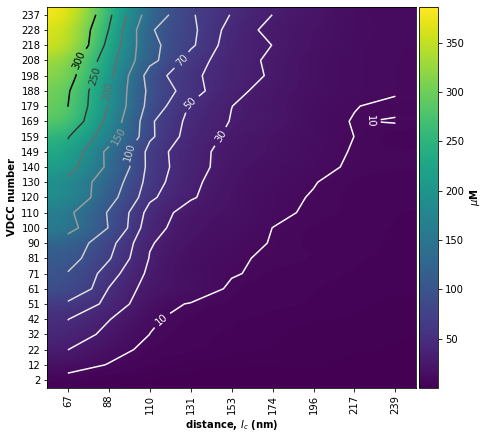

In [177]:
%matplotlib inline
from scipy.constants import N_A
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(7,7))

#count_to_micromolesPliter = count/AvogadroN/volume_in_m3/1000*1e6
peakCa2conc_uMoles = np.max(res_avg[:,:,-1,:], axis=2)/N_A/sum([mesh.getTetVol(i) for i in CaSensTets])/1e3 * 1e6
img = ax.imshow(peakCa2conc_uMoles,
                interpolation='bicubic',
                origin='lower',
               aspect='auto')

ct=plt.contour(range(peakCa2conc_uMoles.shape[1]),
               range(peakCa2conc_uMoles.shape[0]),
               peakCa2conc_uMoles,
               levels=[10, 30, 50, 70, 100, 150, 200, 250, 300],
               cmap='Greys') 
plt.clabel(ct,fmt='%d')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax)
cbar.set_label('$\mu$M', weight='bold')


tmp = ax.set_yticks(list(reversed([i for i in range(len(CaConcs))])))
# ax.set_ylim(len(CaConcs)-0.5, -0.5) # to fix the Matplotlib bug
tmp = ax.set_xticks([i for i in range(len(middists))])
# CaConcsToCounts = [int(float(CaConc) * 15 * 3.8e13 * NotCaSensTris_area) for CaConc in CaConcs]

tmp = ax.set_yticklabels(list(reversed([i for i in VDCC_counts_sorted])))
tmp = ax.set_xticklabels([int(i*1e9) for i in middists], rotation=90)
ax.set_ylabel('VDCC number', weight='bold')
ax.set_xlabel('distance, $I_c$ (nm)', weight='bold')

fig.savefig('hm.svg', format='svg')

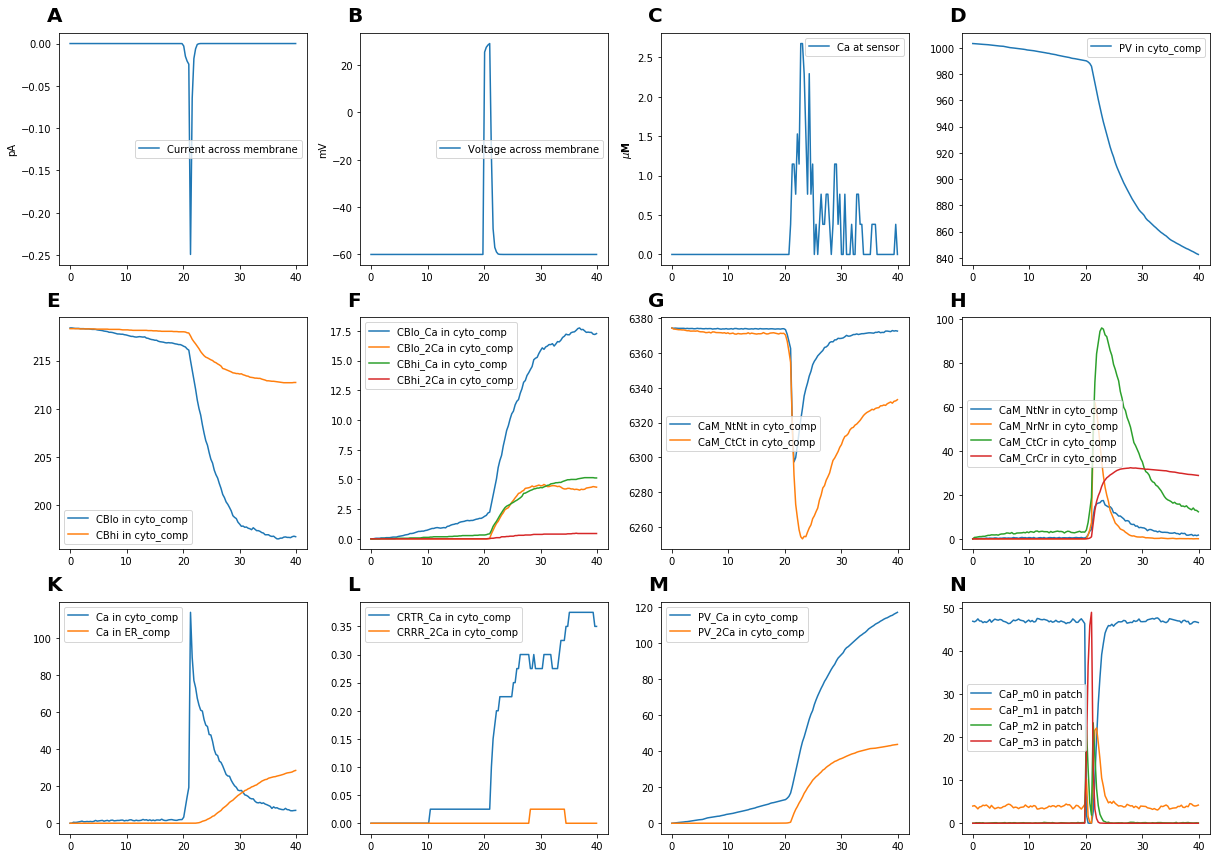

In [178]:
%matplotlib inline

dist_nm     = 250
VDCC_count  = 48

i = findIdxOfClosest([i*1e9 for i in middists_nm], dist_nm)
j = findIdxOfClosest(VDCC_counts_sorted, VDCC_count)

tit1 = 'Number of VDCCs in cluster: {}'.format(VDCC_counts_sorted[conc_id])
tit2 = 'Distance between VDCC and sensor: {:.0f} (nm)'.format(middists_nm[distance_id]*1e9)

tit1 = 'Number of VDCCs in cluster: {}'.format(CaConcs[conc_id])
tit2 = 'Distance between VDCC and sensor: {:.0f} (nm)'.format(middists_nm[distance_id]*1e9)

def PlotMeanSpec(spec, VDCC_count, dist, specs, res, tpnts, molar=False):
#     idx = [i for i,j in enumerate(specs) if j[0]==spec]
    for i, j in enumerate(specs):
        if j[0]==spec:
            NN = np.mean(res[:,VDCC_count,dist,i,:], axis=0)  
            if molar:
                volCompCubicM = sim.getCompVol(j[1])
                NN = count2umPL(NN, volCompCubicM)
                plt.ylabel('$\mu$M', weight='bold')
            plt.plot(tpnts*1e3, NN , label='{} in {}'.format(specs[i][0], specs[i][1]))
    plt.legend()
    
    
fig = plt.figure(figsize=(17,12))

plt.subplot(3,4,1)
ax = plt.gca()
ax.plot(tpnts*1e3, np.mean(res[:,j,i,-3,:].squeeze(), axis=0)*1e12, label='{} across {}'.format('Current', 'membrane'))
ax.set_ylabel('pA')
ax.text(-0.05, 1.05, 'A', transform=ax.transAxes, size=20, weight='bold')
ax.legend()

plt.subplot(3,4,2)
ax = plt.gca()
ax.plot(tpnts*1e3, np.mean(res[:,j,i,-2,:].squeeze(), axis=0)*1e3, label='{} across {}'.format('Voltage', 'membrane'))
ax.text(-0.05, 1.05, 'B', transform=ax.transAxes, size=20, weight='bold')
ax.set_ylabel('mV')
ax.legend()

plt.subplot(3,4,3)
Ca_n = np.mean(res[:,j,i,-1,:].squeeze(), axis=0)
volCaSensTetsInCubicM = sum([mesh.getTetVol(i) for i in CaSensTets])
conc_uM = count2umPL(Ca_n, volCaSensTetsInCubicM)
ax = plt.gca()
ax.plot(tpnts*1e3, conc_uM, label='{} at {}'.format('Ca', 'sensor'))
ax.set_ylabel('$\mu$M', weight='bold')
ax.text(-0.05, 1.05, 'C', transform=ax.transAxes, size=20, weight='bold')
ax.legend()

plt.subplot(3,4,4)
ax = plt.gca()
ax.text(-0.05, 1.05, 'D', transform=ax.transAxes, size=20, weight='bold')
PlotMeanSpec('PV', j, i, specs, res, tpnts)

plt.subplot(3,4,5)
ax = plt.gca()
ax.text(-0.05, 1.05, 'E', transform=ax.transAxes, size=20, weight='bold')
PlotMeanSpec('CBlo', j, i, specs, res, tpnts)
PlotMeanSpec('CBhi', j, i, specs, res, tpnts)

plt.subplot(3,4,6)
ax = plt.gca()
ax.text(-0.05, 1.05, 'F', transform=ax.transAxes, size=20, weight='bold')

PlotMeanSpec('CBlo_Ca', j, i, specs, res, tpnts)
PlotMeanSpec('CBlo_2Ca', j, i, specs, res, tpnts)
PlotMeanSpec('CBhi_Ca', j, i, specs, res, tpnts)
PlotMeanSpec('CBhi_2Ca', j, i, specs, res, tpnts)

plt.subplot(3,4,7)
ax = plt.gca()
ax.text(-0.05, 1.05, 'G', transform=ax.transAxes, size=20, weight='bold')

PlotMeanSpec('CaM_NtNt', j, i, specs, res, tpnts)
PlotMeanSpec('CaM_CtCt', j, i, specs, res, tpnts)

plt.subplot(3,4,8)
ax = plt.gca()
ax.text(-0.05, 1.05, 'H', transform=ax.transAxes, size=20, weight='bold')

PlotMeanSpec('CaM_NtNr', j, i, specs, res, tpnts)
PlotMeanSpec('CaM_NrNr', j, i, specs, res, tpnts)
PlotMeanSpec('CaM_CtCr', j, i, specs, res, tpnts)
PlotMeanSpec('CaM_CrCr', j, i, specs, res, tpnts)

# plt.subplot(4,4,9)
# PlotMeanSpec('CRTT', j, i, specs, res, tpnts)
# PlotMeanSpec('CRind', j, i, specs, res, tpnts)

plt.subplot(3,4,9)
ax = plt.gca()
ax.text(-0.05, 1.05, 'K', transform=ax.transAxes, size=20, weight='bold')
PlotMeanSpec('Ca', j, i, specs, res, tpnts, molar=False)

plt.subplot(3,4,10)
ax = plt.gca()
ax.text(-0.05, 1.05, 'L', transform=ax.transAxes, size=20, weight='bold')

PlotMeanSpec('CRTR_Ca', j, i, specs, res, tpnts)
PlotMeanSpec('CRRR_2Ca', j, i, specs, res, tpnts)

plt.subplot(3,4,11)
ax = plt.gca()
ax.text(-0.05, 1.05, 'M', transform=ax.transAxes, size=20, weight='bold')

PlotMeanSpec('PV_Ca', j, i, specs, res, tpnts)
PlotMeanSpec('PV_2Ca', j, i, specs, res, tpnts)

plt.subplot(3,4,12)
ax = plt.gca()
ax.text(-0.05, 1.05, 'N', transform=ax.transAxes, size=20, weight='bold')

PlotMeanSpec('CaP_m0', j, i, specs, res, tpnts)
PlotMeanSpec('CaP_m1', j, i, specs, res, tpnts)
PlotMeanSpec('CaP_m2', j, i, specs, res, tpnts)
PlotMeanSpec('CaP_m3', j, i, specs, res, tpnts)

plt.tight_layout()
fig.savefig('dyn.svg', format='svg')

In [27]:
sim.getPatchCount('memb_surf', 'PMCA_P0') + 

423.0

In [157]:
sim.getCompVol('cyto_comp')*1e18

0.36612753313879287

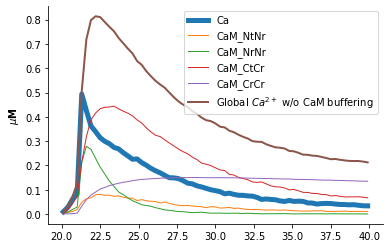

In [168]:
molar = True

fig = plt.figure()
volCompCubicM = sim.getCompVol('cyto_comp')

# plt.plot(count2umPL(np.mean(res[:,j,i,0,67:], axis=0), volCompCubicM), linewidth=5, label=specs[0][0])
# plt.plot(np.mean(res[:,j,i,7,67:], axis=0), label=specs[7][0])
# plt.plot(np.mean(res[:,j,i,8,67:], axis=0), label=specs[8][0])
# plt.plot(np.mean(res[:,j,i,10,67:], axis=0), label=specs[10][0])
# plt.plot(np.mean(res[:,j,i,11,67:], axis=0), label=specs[11][0])



NN = np.mean(res[:,j,i,7,67:], axis=0) +\
np.mean(res[:,j,i,8,67:], axis=0) +\
np.mean(res[:,j,i,10,67:], axis=0) +\
np.mean(res[:,j,i,11,67:], axis=0)# +\
# np.mean(res[:,j,i,19,67:], axis=0) +\
# np.mean(res[:,j,i,20,67:], axis=0)
    
if molar:
    plt.plot(tpnts[67:]*1e3, count2umPL(np.mean(res[:,j,i,0,67:], axis=0), volCompCubicM), linewidth=5, label=specs[0][0])
    plt.plot(tpnts[67:]*1e3, count2umPL(np.mean(res[:,j,i,7,67:], axis=0), volCompCubicM), linewidth=1, label=specs[7][0])
    plt.plot(tpnts[67:]*1e3, count2umPL(np.mean(res[:,j,i,8,67:], axis=0), volCompCubicM), linewidth=1, label=specs[8][0])
    plt.plot(tpnts[67:]*1e3, count2umPL(np.mean(res[:,j,i,10,67:], axis=0), volCompCubicM), linewidth=1, label=specs[10][0])
    plt.plot(tpnts[67:]*1e3, count2umPL(np.mean(res[:,j,i,11,67:], axis=0), volCompCubicM), linewidth=1, label=specs[11][0])
    plt.plot(tpnts[67:]*1e3, count2umPL(NN, volCompCubicM), linewidth=2, label='Global $Ca^{2+}$ w/o CaM buffering')
    plt.ylabel('$\mu$M', weight='bold')
else:
    plt.plot(tpnts[67:]*1e3, np.mean(res[:,j,i,0,67:], axis=0), linewidth=5, label=specs[0][0])
    plt.plot(tpnts[67:]*1e3, np.mean(res[:,j,i,7,67:], axis=0), linewidth=1, label=specs[7][0])
    plt.plot(tpnts[67:]*1e3, np.mean(res[:,j,i,8,67:], axis=0), linewidth=1, label=specs[8][0])
    plt.plot(tpnts[67:]*1e3, np.mean(res[:,j,i,10,67:], axis=0), linewidth=1, label=specs[10][0])
    plt.plot(tpnts[67:]*1e3, np.mean(res[:,j,i,11,67:], axis=0),linewidth=1, label=specs[11][0])
    plt.plot(tpnts[67:]*1e3, NN, linewidth=2, label='Global $Ca^{2+}$ w/o CaM buffering')

plt.legend()
ax = plt.gca()
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

fig.savefig('fig4.svg', format='svg')

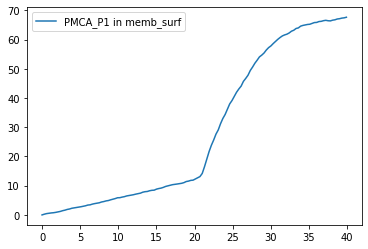

In [100]:
# PlotMeanSpec('PMCA_P0', j, i, specs, res, tpnts, molar=False)
PlotMeanSpec('PMCA_P1', j, i, specs, res, tpnts, molar=False)

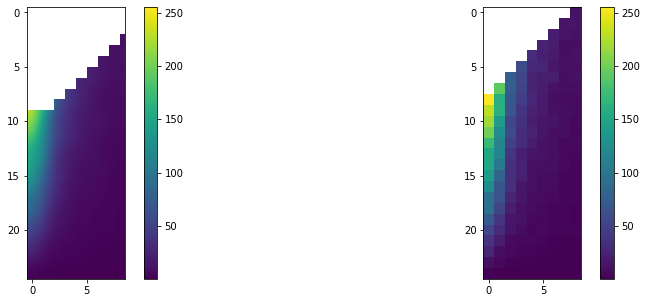

In [125]:
plt.figure(figsize=(15,5))
d = np.flipud(np.copy(peakCa2conc_uMoles))
# d[:,-2:] = 5

d1 = np.copy(d)
d1 = np.rot90(np.rot90(np.rot90(np.triu(np.rot90(d1)))))
for i in range(d1.shape[0]):
    for j in range(d1.shape[1]):
        if d1[i,j]==0:
            d1[i,j] = np.nan

plt.subplot(1,2,1)
plt.imshow(d1, interpolation='bicubic')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(d1)
plt.colorbar()